In [1]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io


# from tqdm import tqdm_notebook 
from tqdm.notebook import tqdm 
import random

import sentencepiece as spm
from konlpy.tag import Mecab

# Step 1. 데이터 다운로드
   

In [2]:
# train data load
data_dir = os.getenv('HOME')+'/aiffel/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

# test data loading
kor_path_test =data_dir+"/korean-english-park.test.ko"
eng_path_test =data_dir+"/korean-english-park.test.en"

# Step 2. 데이터 정제 및 토큰화

In [3]:
# Train 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    with open(kor_path, "r") as f: kor = f.read().splitlines()

    assert len(kor) == len(eng) # kor, eng가 같은 갯수라는 것을 검증받기 위해 적용

    cleaned_corpus = list(set(zip(eng, kor)))  # 중복된 데이터 제거
    
    return cleaned_corpus

cleaned_corpus = clean_corpus(eng_path, kor_path)
len(cleaned_corpus)

78968

In [4]:
# Test 데이터 정제 및 토큰화
def clean_corpus_test(kor_path_test, eng_path_test):
    with open(eng_path_test, "r") as f: eng_test = f.read().splitlines()
    with open(kor_path_test, "r") as f: kor_test = f.read().splitlines()

    assert len(kor_test) == len(eng_test) # kor, eng가 같은 갯수라는 것을 검증받기 위해 적용

    cleaned_corpus_test = list(set(zip(eng_test, kor_test)))  # 중복된 데이터 제거
    
    return cleaned_corpus_test

cleaned_corpus_test = clean_corpus_test(eng_path_test, kor_path_test)
len(cleaned_corpus_test)

1996

In [7]:
cleaned_corpus[:1]

[('바트 고든 민주당 하원의원도 “그것은 옳지 못한 행동”이라고 지적했다.',
  '"That\'s not the \'right stuff\' as far as I\'m concerned," said Bart Gordon, D-Tennessee.')]

In [6]:
cleaned_corpus_test[:1]

[('올메리트 총리는 “팔레스타인 자치정부와 이스라엘이 이전에 한 번도 이루지 못한 중대한 문제들의 최종 합의에 착수하게 될 것”이라고 덧붙였다.',
  '¡°I think we are coming to a moment at which the Palestinian Authority and the state of Israel¡± will undertake serious issues ¡°that will take us finally to a point at which we have never been before ,¡± Olmert added.')]

In [8]:
# cleaned_corpus+=cleaned_corpus_test

In [9]:
len(cleaned_corpus)

78968

In [10]:
# 1. 모든 입력을 소문자로 변환합니다.
# 2. 알파벳, 문장부호, 한글만 남기고 모두 제거합니다.
# 3. 문장부호 양옆에 공백을 추가합니다.
# 4. 문장 앞뒤의 불필요한 공백을 제거합니다.

def preprocess_sentence(sentence):

    sentence = sentence.lower() #1
    sentence = re.sub(r"[^a-zA-Z가-힣?.!,]+", " ", sentence) #2
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence) #3
    sentence = re.sub(r'[" "]+', " ", sentence) #4
    
    return sentence

In [11]:
# 한글 말뭉치 kor_corpus 와 영문 말뭉치 eng_corpus 를 각각 분리한 후, 정제하여 토큰화를 진행
# 최종적으로 ko_tokenizer 과 en_tokenizer 를 얻기
# en_tokenizer에는 set_encode_extra_options("bos:eos") 함수를 실행해 타겟 입력이 문장의 시작 토큰과 끝 토큰을 포함할 수 있게
# 단어 사전을 매개변수로 받아 원하는 크기의 사전을 정의할 수 있게 합니다. (기본: 20,000)
# 학습 후 저장된 model 파일을 SentencePieceProcessor() 클래스에 Load()한 후 반환합니다.
# 특수 토큰의 인덱스를 아래와 동일하게 지정합니다.
# <PAD> : 0 / <BOS> : 1 / <EOS> : 2 / <UNK> : 3

# Sentencepiece를 활용하여 학습한 tokenizer를 생성
def generate_tokenizer(corpus, vocab_size, lang="en", pad_id=0, bos_id=1, eos_id=2, unk_id=3):

    temp_file = os.getenv('HOME') + f'/aiffel/data/corpus_{lang}.txt'     # corpus를 받아 txt파일로 저장
    
    with open(temp_file, 'w') as f:
        for row in corpus:
            f.write(str(row) + '\n')
    
    # Sentencepiece를 이용해 
    spm.SentencePieceTrainer.Train(
        f'--input={temp_file} --pad_id={pad_id} --bos_id={bos_id} --eos_id={eos_id} \
        --unk_id={unk_id} --model_prefix=spm{lang}_r2 --vocab_size={vocab_size}'   # model_r1
    )
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(f'spm{lang}_r2.model') # model_r1

    return tokenizer

In [12]:
SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 25000

eng_corpus = []
kor_corpus = []

for pair in cleaned_corpus:
    k, e = pair[0], pair[1]
    # kor, eng 나눠서 데이터 정제 후 분리
    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))

en_tokenizer = generate_tokenizer(eng_corpus, SRC_VOCAB_SIZE, "en")
ko_tokenizer = generate_tokenizer(kor_corpus, TGT_VOCAB_SIZE, "ko")
ko_tokenizer.set_encode_extra_options("bos:eos")

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/data/corpus_en.txt --pad_id=0 --bos_id=1 --eos_id=2         --unk_id=3 --model_prefix=spmen_r2 --vocab_size=25000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/data/corpus_en.txt
  input_format: 
  model_prefix: spmen_r2
  model_type: UNIGRAM
  vocab_size: 25000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1


True

In [13]:
eng_corpus[100]

'even the local stock market seems affected by the nasty weather . '

In [14]:
kor_corpus[100]

'주식 시장조차 궂은 날씨에 영향을 받은 것으로 보인다 . '

In [49]:
# Test data
SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 25000

eng_corpus_test = []
kor_corpus_test = []

for pair in cleaned_corpus_test:
    k, e = pair[0], pair[1]
    # kor, eng 나눠서 데이터 정제 후 분리
    kor_corpus_test.append(preprocess_sentence(k))
    eng_corpus_test.append(preprocess_sentence(e))

# en_test_tokenizer = generate_tokenizer(eng_corpus, SRC_VOCAB_SIZE, "en")
# ko_test_tokenizer = generate_tokenizer(kor_corpus, TGT_VOCAB_SIZE, "ko")
# ko_test_tokenizer.set_encode_extra_options("bos:eos")

문장의 최단 길이: 1
문장의 최장 길이: 611
문장의 평균 길이: 135


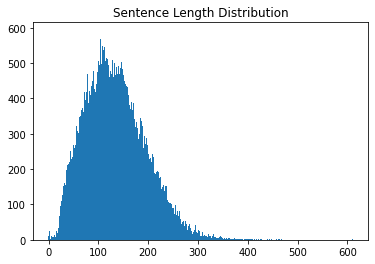

In [15]:
# eng_corpus 통계

min_len = 999
max_len = 0
sum_len = 0


for sen in eng_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(eng_corpus))

sentence_length = np.zeros((max_len), dtype=int)

#총 max_len의 배열을 만든 후, raw 문장을 돌면서 각 문장별 길이를 sentence_length의 len(sen) 인덱스마다  계속 더해가면서 counting
for sen in eng_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

문장의 최단 길이: 1
문장의 최장 길이: 331
문장의 평균 길이: 64


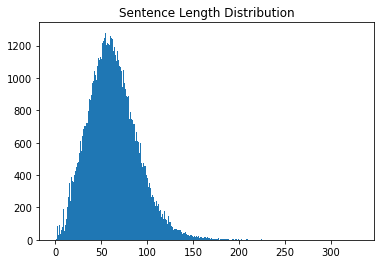

In [16]:
# kor_corpus 통계

min_len = 999
max_len = 0
sum_len = 0


for sen in kor_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(kor_corpus))

sentence_length = np.zeros((max_len), dtype=int)

#총 max_len의 배열을 만든 후, raw 문장을 돌면서 각 문장별 길이를 sentence_length의 len(sen) 인덱스마다  계속 더해가면서 counting
for sen in kor_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [21]:
# max_tokens = np.mean(num_tokens) + 2.5 * np.std(num_tokens)
# maxlen = int(max_tokens)
# print('pad_sequences maxlen : ', maxlen)
# print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)*100}%가 maxlen 설정값 이내에 포함됩니다.')

In [17]:
# 토크나이저를 활용해 토큰의 길이가 50 이하인 데이터를 선별하여 src_corpus 와 tgt_corpus 를 각각 구축하고, 텐서 enc_train 과 dec_train 으로 변환
src_corpus = [] #영어
tgt_corpus = [] #한글

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 xxx 이하인 문장만 남깁니다. 
for idx in tqdm(range(len(kor_corpus))):
    src = en_tokenizer.EncodeAsIds(eng_corpus[idx])
    tgt = ko_tokenizer.EncodeAsIds(kor_corpus[idx])
    
    if len(src) <= 120 and len(tgt) <= 100: 
        src_corpus.append(src)
        tgt_corpus.append(tgt)

# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

  0%|          | 0/78968 [00:00<?, ?it/s]

In [18]:
# # 훈련 데이터와 검증 데이터로 분리하기
# enc_train, enc_val, dec_train, dec_val = train_test_split(enc_data, dec_data, test_size=0.05)

In [19]:
# enc, dec 의 seq_length는 달라도 상관없음.
print(enc_train.shape)
print(dec_train.shape)
# print(enc_val.shape)
# print(dec_val.shape)

(78967, 116)
(78967, 95)


In [20]:
# en_tokenizer.encode_as_pieces(eng_corpus[100])

# Step 3. 모델설계

## Positional Encoding

In [21]:
# pos - 단어가 위치한 Time-step(각각의 토큰의 위치정보값이며 정수값을 의미)
# d_model - 모델의 Embedding 차원 수
# i - Encoding차원의 index

def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i)/d_model)  # np.power(a,b) > a^b(제곱)
    
    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]
    
    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    
    # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    
    return sinusoid_table

## Multi-Head Attention

In [22]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model)  # Linear Layer
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)
        
    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        
        # Scaled QK 값 구하기
        QK = tf.matmul(Q, K, transpose_b=True)
        scaled_qk = QK / tf.math.sqrt(d_k)
        
        if mask is not None:
            scaled_qk += (mask * -1e9)
        
        # 1. Attention Weights 값 구하기 -> attentions
        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        # 2. Attention 값을 V에 곱하기 -> out
        out = tf.matmul(attentions, V)
        return out, attentions
    
    def split_heads(self, x):
        """
        Embedding된 입력을 head의 수로 분할하는 함수
        
        x: [ batch x length x emb ]
        return: [ batch x length x heads x self.depth ]
        """
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])
        return split_x
    
    def combine_heads(self, x):
        """
        분할된 Embedding을 하나로 결합하는 함수
        
        x: [ batch x length x heads x self.depth ]
        return: [ batch x length x emb ]
        """
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))
        return combined_x
    
    def call(self, Q, K, V, mask):
        """
        Step 1: Linear_in(Q, K, V) -> WQ, WK, WV
        Step 2: Split Heads(WQ, WK, WV) -> WQ_split, WK_split, WV_split
        Step 3: Scaled Dot Product Attention(WQ_split, WK_split, WV_split)
                 -> out, attention_weights
        Step 4: Combine Heads(out) -> out
        Step 5: Linear_out(out) -> out
        """
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask
        )
        
        out = self.combine_heads(out)
        out = self.linear(out)
        
        return out, attention_weights

## Position-wise Feed-Forward Network

In [23]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

print("슝=3")

슝=3


d_ff 는 논문의 설명대로라면 2048 일 거고, d_model 은 512  [ batch x length x d_model ] 의 입력을 받아 w_1 이 2048차원으로 매핑하고 활성함수 ReLU를 적용한 후, 다시 w_2 를 통해 512차원으로 되돌리는 과정

## Encoder 레이어 구현하기

In [24]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)
        
        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        # Multi-Head Attention
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual*1 
        
        # Position-Wise Feed Forward Network
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual*1 
        
        return out, enc_attn

## Decoder 레이어 구현하기

In [25]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, enc_out, causality_mask, padding_mask):
        # Masked Multi-Head Attention
        residual = x
        out = self.norm_1(x)
        #out, dec_attn = self.dec_self_attn(out, out, out, causality_mask)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual
        
        # Multi-Head Attention
        residual = out
        out = self.norm_2(out)
        #out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, padding_mask)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.do(out)
        out += residual

        # Position-Wise Feed Forward Network
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

## Encoder와 Decoder 클래스를 정의
EncodeLayer 와 DecoderLayer 를 모두 정의했으니 이를 조립하는 것은 어렵지 않겠죠? 이를 이용해 Encoder와 Decoder 클래스를 정의합니다.

In [26]:
class Encoder(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)]
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
            
        return out, enc_attns

In [27]:
class Decoder(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)]
        
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = self.dec_layers[i](out, enc_out, causality_mask, padding_mask)
            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)
        
        return out, dec_attns, dec_enc_attns

## Transformer 완성하기


In [28]:
class Transformer(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, src_vocab_size, tgt_vocab_size,
                 pos_len, dropout=0.2, shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        
        # 1. Embedding Layer 정의
        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)
        
        # 2. Positional Encoding 정의
        self.pos_encoding = positional_encoding(pos_len, d_model)
        # 6. Dropout 정의
        self.do = tf.keras.layers.Dropout(dropout)
        
        # 3. Encoder / Decoder 정의
        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)
        
        # 4. Output Linear 정의
        self.fc = tf.keras.layers.Dense(tgt_vocab_size)
        
        # 5. Shared Weights
        self.shared = shared
        
        if shared:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))
        
        
    def embedding(self, emb, x):
        """
        입력된 정수 배열을 Embedding + Pos Encoding
        + Shared일 경우 Scaling 작업 포함

        x: [ batch x length ]
        return: [ batch x length x emb ]
        """
        seq_len = x.shape[1]
        out = emb(x)
        
        if self.shared:
            out *= tf.math.sqrt(self.d_model)
        
        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)
        
        return out
    
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        # Step 1: Embedding(enc_in, dec_in) -> enc_in, dec_in
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)
        
        # Step 2: Encoder(enc_in, enc_mask) -> enc_out, enc_attns
        enc_out, enc_attns = self.encoder(enc_in, enc_mask)

        # Step 3: Decoder(dec_in, enc_out, mask) -> dec_out, dec_attns, dec_enc_attns
        dec_out, dec_attns, dec_enc_attns = self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        # Step 4: Out Linear(dec_out) -> logits
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns
    

## Mask

In [29]:
# Attention을 할 때에 <PAD> 토큰에도 Attention을 주는 것을 방지해 주는 역할
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

# Step 4. 훈련하기

In [30]:
transformer = Transformer(
    n_layers=6,
    d_model=512,
    n_heads=8,
    d_ff=2048,
    src_vocab_size=SRC_VOCAB_SIZE,
    tgt_vocab_size=TGT_VOCAB_SIZE,
    pos_len=200,
    dropout=0.1,
    shared=True
)

##  Learning Rate Scheduler를 선언하고, 이를 포함하는 Adam Optimizer를 선언

In [31]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [32]:
learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

## Loss 함수를 정의


In [33]:
# Loss 함수 정의
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

## train_step 함수를 정의


In [34]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

In [35]:
ckpt = tf.train.Checkpoint(step = tf.Variable(1), optimizer = optimizer , transformer = transformer)
manager = tf.train.CheckpointManager(ckpt, './tf_ckpts_gd12_r1',max_to_keep=2)

## Attention 시각화 함수

In [36]:
# Attention 시각화 함수
def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

## 번역생성함수

In [37]:
# 번역 생성 함수
def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)
    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens], maxlen=enc_train.shape[-1], padding='post')

    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = generate_masks(_input, output)
        

        predictions, enc_attns, dec_attns, dec_enc_attns = model(_input, output, enc_padding_mask, combined_mask, dec_padding_mask)
        
        predicted_id = tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()
        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)
    result = tgt_tokenizer.decode_ids(ids)
    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [42]:
# 번역 생성 및 Attention 시각화 결합
def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)
  
    return result

In [43]:
examples = [
    "How was your day? I was the best.",
    "Take your time, please.",
    "I’m about to leave. Please hold for a moment.",
    "Have you heard of it?"
]

## 학습

In [44]:
# 학습
EPOCHS = 5
BATCH_SIZE = 64

def train_and_checkpoint(transformer, manager, EPOCHS):
    ckpt.restore(manager.latest_checkpoint)
    if manager.latest_checkpoint:
        print("Restored from {}".format(manager.latest_checkpoint))
    
    else:
        print("Initializing from scratch.")


    for epoch in range(EPOCHS):
        total_loss = 0

        idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
        random.shuffle(idx_list)
        t = tqdm(idx_list)

        for (batch, idx) in enumerate(t):
            batch_loss, enc_attns, dec_attns, dec_enc_attns = train_step(enc_train[idx:idx+BATCH_SIZE],
                                                                         dec_train[idx:idx+BATCH_SIZE],
                                                                         transformer,
                                                                         optimizer)

            total_loss += batch_loss

            t.set_description_str('Epoch %2d' % (epoch + 1))
            t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
      
      
        # 매 Epoch 마다 제시된 예문에 대한 번역 생성
        for example in examples:
            translate(example, transformer, en_tokenizer, ko_tokenizer)
            
 
        if int(ckpt.step) % 2 == 0:
            save_path = manager.save()
            print("Saved checkpoint for step {}: {}".format(int(ckpt.step), save_path))

In [45]:
train_and_checkpoint(transformer, manager, EPOCHS )

Initializing from scratch.


  0%|          | 0/1234 [00:00<?, ?it/s]

Input: How was your day? I was the best.
Predicted translation: 그는 이 같은 날을 어떻게 사랑했다 .
Input: Take your time, please.
Predicted translation: 그는 시간 동안 돈을 받게 될 것입니다 .
Input: I’m about to leave. Please hold for a moment.
Predicted translation: 그는 일 오후 시 분의 한 남자를 타고 있었다 .
Input: Have you heard of it?
Predicted translation: 그는 나는 나는 나는 내가 어떻게 어떻게 어떻게 어떻게 어떻게 어떻게 어떻게 어떻게 어떻게 어떻게 어떻게 합니다 .


  0%|          | 0/1234 [00:00<?, ?it/s]

Input: How was your day? I was the best.
Predicted translation: 얼마나 많은 사람들이 얼마나 나를  ⁇ 니다 .
Input: Take your time, please.
Predicted translation: 그러나 당신은 당신에게 더 빨리를 즐길 수 있다 .
Input: I’m about to leave. Please hold for a moment.
Predicted translation: 그는 또는 사람들이 나를 치며 내가 나를  ⁇ 다 고 덧붙였다 .
Input: Have you heard of it?
Predicted translation: 내가 ?


  0%|          | 0/1234 [00:00<?, ?it/s]

Input: How was your day? I was the best.
Predicted translation: 원문기사보기
Input: Take your time, please.
Predicted translation: to be the u . s . s . s .
Input: I’m about to leave. Please hold for a moment.
Predicted translation: 나는 나는 나는 나는 나는 다시한번 땅을 잃고 있다 .
Input: Have you heard of it?
Predicted translation: 내가 원하는 것은 아니다 .


  0%|          | 0/1234 [00:00<?, ?it/s]

Input: How was your day? I was the best.
Predicted translation: 어떻게든지에 대해 어떻게 말했는지는 모른다 .
Input: Take your time, please.
Predicted translation: 시간이 필요하면 시간이 지났을 수도 있습니다 .
Input: I’m about to leave. Please hold for a moment.
Predicted translation: 그는 일 현지시간 열린 경기에 출전해 다시 이곳에 왔지만 나는 내가 잊을 수 없다 고 말했다 .
Input: Have you heard of it?
Predicted translation: 내 블로그에 저장


  0%|          | 0/1234 [00:00<?, ?it/s]

Input: How was your day? I was the best.
Predicted translation: 그는 하루 평균 번의 날을 받았다 .
Input: Take your time, please.
Predicted translation: 필요하면 시간이 일을  ⁇ 다 .
Input: I’m about to leave. Please hold for a moment.
Predicted translation: 나는 그를 위해 기도를 해야한다 .
Input: Have you heard of it?
Predicted translation: 내가 우리에게요 .


In [46]:
for example in examples:
    translate(example, transformer, en_tokenizer, ko_tokenizer)

Input: How was your day? I was the best.
Predicted translation: 그는 하루 평균 번의 날을 받았다 .
Input: Take your time, please.
Predicted translation: 필요하면 시간이 일을  ⁇ 다 .
Input: I’m about to leave. Please hold for a moment.
Predicted translation: 나는 그를 위해 기도를 해야한다 .
Input: Have you heard of it?
Predicted translation: 내가 우리에게요 .


# Step 5. 평가

In [47]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

def eval_bleu_single(model, src_sentence, tgt_sentence, en_tokenizer, ko_tokenizer, verbose=True):
    src_tokens = en_tokenizer.encode_as_ids(src_sentence)
    tgt_tokens = ko_tokenizer.encode_as_ids(tgt_sentence)

    if (len(src_tokens) > 120): return None
    if (len(tgt_tokens) > 100): return None

    reference = tgt_sentence.split()
    candidate = translate(src_sentence, model, en_tokenizer, ko_tokenizer).split()

    score = sentence_bleu([reference], candidate,
                          smoothing_function=SmoothingFunction().method1)

    if verbose:
        print("Source Sentence: ", src_sentence)
        print("Model Prediction: ", candidate)
        print("Real: ", reference)
        print("Score: %lf\n" % score)
        
    return score

In [50]:
# single test
test_idx = 2

eval_bleu_single(transformer, 
                 eng_corpus_test[test_idx], 
                 kor_corpus_test[test_idx], 
                 en_tokenizer, 
                 ko_tokenizer, 
                 verbose=True)

Input: that s according to a producer who worked with the actress . 
Predicted translation: 이는 영화의 홍보를 위해 할 수 있는 한 여배우가 이루어졌다 .
Source Sentence:  that s according to a producer who worked with the actress . 
Model Prediction:  ['이는', '영화의', '홍보를', '위해', '할', '수', '있는', '한', '여배우가', '이루어졌다', '.']
Real:  ['이', '소식은', '이', '여배우와', '함께', '일했던', '한', '프로듀서로부터', '나왔습니다', '.']
Score: 0.022417



0.022416933501922302

In [51]:
def eval_bleu(model, src_sentences, tgt_sentence, en_tokenizer, ko_tokenizer, verbose=True):
    total_score = 0.0
    sample_size = len(src_sentences)
    
    for idx in tqdm(range(sample_size)):
        score = eval_bleu_single(model, src_sentences[idx], tgt_sentence[idx], en_tokenizer, ko_tokenizer, verbose)
        if not score: continue
        
        total_score += score
    
    print("Num of Sample:", sample_size)
    print("Total Score:", total_score / sample_size)

In [52]:
len(eng_corpus_test)

1996

In [53]:
eval_bleu(transformer, eng_corpus_test[:100], kor_corpus_test[:100], en_tokenizer, ko_tokenizer, verbose=False)

  0%|          | 0/100 [00:00<?, ?it/s]

Input:  i think we are coming to a moment at which the palestinian authority and the state of israel will undertake serious issues that will take us finally to a point at which we have never been before , olmert added . 
Predicted translation: 올메르트 총리는 이스라엘의 팔레스타인 영토인 에후드 올메르트와의 관계를 정상화하기 위해 노력하고 있다 며 이스라엘에 심각한 문제가 될 것 이라고 밝혔다 .
Input: peter robinson , northern ireland s first secretary , tells sky news people do not want to go back to the time of the troubles 
Predicted translation: 영한사전 약어표 한영사전 약어표
Input: that s according to a producer who worked with the actress . 
Predicted translation: 이는 영화의 홍보를 위해 할 수 있는 한 여배우가 이루어졌다 .
Input: the plaster cast was fitted at fairfield general hospital in bury , near manchester , two months ago after talks broke his right leg when he fell whilst walking his dog . 
Predicted translation: 그는 개월 전 세계 랭킹 위인 파멜라 홀타니가 병원에서 치료를 받았다 .
Input: jumped cents to . a barrel after setting a high of . . 
Predicted translation: 센트는 센트 올랐다 .
Input: while the human 

Input:  cnn police in western china shot and killed five people in a group that was planning a holy war against han chinese , the largest ethnic group in china , police told china s xinhua news agency wednesday . 
Predicted translation: 중국 관영 언론은 일 현지시간 중국 남서부에서 명을 사살했다고 밝혔다 .
Input: we re worried about battery life some early reviews indicate that the iphone g lasts only a day but we ll run full tests over the next couple of days and report our results on this page . 
Predicted translation: 그는 마지막날 아침 에는  ⁇ 막에 대해 좀더 자세하게 나타나길 바란다 며 그러나 결과는 특히 새가 될 것 이라고 덧붙였다 .
Input: the connecticut based company building the orion toilet needs the large volume of urine about the daily output of people to work on urine acidity problems , said spokesman leo makowski . 
Predicted translation: 영국 내무부 대변인은 자체 개발한 변기를 인용해 자사의 상황이 민감해질 수 있다는 사실 이라며 이를 통해 문제가 있는 모든 정보를 공개할 수 있도록 도울 것 이라고 밝혔다 .
Input: citing the high prices americans are paying at the pump , bush said from the white house rose garden that all

Input: her doctor also said on monday that fawcett is recovering after a medical procedure in germany , and is not on death s door . 
Predicted translation: 그녀의 주치의인 의사는 일 현지시간 주치의가 생후 개월 만에 환자의 상태를 조사하기 위해 소송을 청구했다고 전했다 .
Input: turkish police have detained four people in connection with wednesday s terrorist attack outside the u . s . consulate in istanbul , the interior minister said thursday . 
Predicted translation: 터키의 경찰은 일 현지시간 이스탄불 중심부를 점령하고 있는 터키 이스탄불에 있는 이스탄불 중심부를 상대로 폭탄 테러를 저질렀다고 밝혔다 .
Input: abe emphasized tokyo will further enhance security cooperation with washington , pledging stern measures against pyongyang . 
Predicted translation: 아베 총리는 , 일본 , 체코와의 협력을 위한 협력을 강화할지도 모른다 .
Input: coots was charged thursday with buying , selling and possessing illegal reptiles . 
Predicted translation: 한편 농심은 일 현지시간 불법 무기를 구입하고 판매하고 불법으로 판매하는 것을 요구했다 .
Input: clemens contends mcnamee defamed him when the trainer , who worked for both pitchers , told pettitte in or that clemens had use

In [ ]:
# # Bleu example
# from datasets import load_metric

# bleu = load_metric("bleu")
# predictions = [["I", "have", "thirty", "six", "years"]] 
# references = [
#     [["I", "am", "thirty", "six", "years", "old"], ["I", "am", "thirty", "six"]]
# ]
# bleu.compute(predictions=predictions, references=references)

# # Bleu example
# from datasets import load_metric

# bleu = load_metric("bleu")
# #bleu = load_metric('sacrebleu')

# reference = [kor_corpus_test.split()]
# predictions = [translate(eng_corpus_test, transformer, en_tokenizer, ko_tokenizer).split()]

# bleu.compute(predictions=predictions, references=reference)

In [ ]:
# import matplotlib as mpl
# import matplotlib.pyplot as plt

# %config InlineBackend.figure_format = 'retina'
 
# import matplotlib.font_manager as fm

# fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
# font = fm.FontProperties(fname=fontpath, size=9)
# plt.rc('font', family='NanumBarunGothic') 
# # mpl.font_manager._rebuild()

In [ ]:
# 매 Epoch 마다 제시된 예문에 대한 번역 생성시각화
# for example in examples:
#     translate(example, transformer, en_tokenizer, ko_tokenizer, plot_attention=True)